In [1]:
#!/usr/bin/env python
# coding: utf-8

#
# # CS 763 - Lab 8 (WGAN-GPs) Part-B

from torch.autograd import grad
from tqdm import tqdm
import time
import sys
import os
import PIL
from torch.nn import functional as F
from torch import nn, optim
from torchvision import transforms, models, datasets
import matplotlib.pyplot as plt
import torchvision
import random
import torch
import numpy as np
# from google.colab import drive
# drive.mount('/content/drive')
# Check for GPU specs
get_ipython().system('nvidia-smi')

# device set to cuda if GPU available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Sun Apr 18 20:13:05 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.45.01    Driver Version: 455.45.01    CUDA Version: 11.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  TITAN RTX           On   | 00000000:03:00.0 Off |                  N/A |
| 51%   73C    P2   206W / 280W |  16981MiB / 24220MiB |     62%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  TITAN Xp            On   | 00000000:81:00.0 Off |                  N/A |
| 27%   

Lenth of Trainset = 60000
Lenth of Testset = 10000
Dimensions of each image = (28,28)


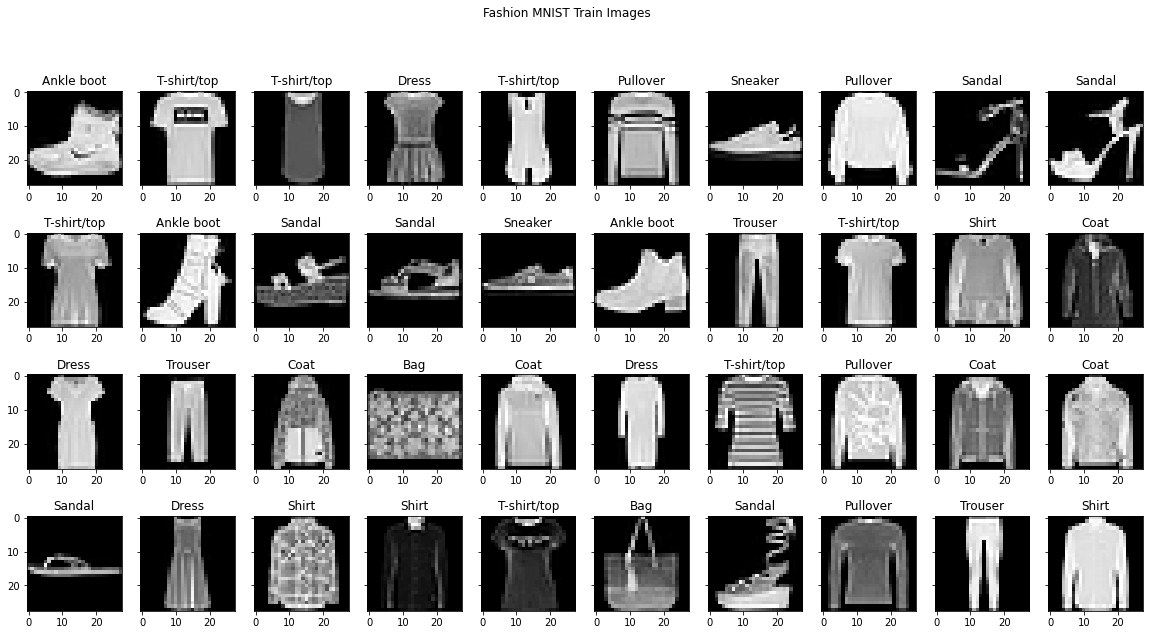

In [2]:
# Function to fix the seed for randomisation

def fix_seed(seed=0):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True


fix_seed(763)

# We will use the Fashion-MNIST dataset for this task
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5), std=(0.5))])

trainset = torchvision.datasets.FashionMNIST(
    './data', download=True, train=True, transform=transform)
testset = torchvision.datasets.FashionMNIST(
    './data', download=True, train=False, transform=transform)

# dataloaders
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=128, num_workers=2, shuffle=True)
testloader = torch.utils.data.DataLoader(
    trainset, batch_size=128, num_workers=2)


# Visualising the dataset
labeldic = {}
labeldic[0] = 'T-shirt/top'
labeldic[1] = 'Trouser'
labeldic[2] = 'Pullover'
labeldic[3] = 'Dress'
labeldic[4] = 'Coat'
labeldic[5] = 'Sandal'
labeldic[6] = 'Shirt'
labeldic[7] = 'Sneaker'
labeldic[8] = 'Bag'
labeldic[9] = 'Ankle boot'
print('Lenth of Trainset = {}'.format(len(trainset)))
print('Lenth of Testset = {}'.format(len(testset)))
print('Dimensions of each image = ({},{})'.format(
    trainset[0][0].shape[1], trainset[0][0].shape[2]))
fig, axs = plt.subplots(4, 10, sharey=True, figsize=(20, 10))
for i in range(40):
    axs[i//10, i % 10].imshow(trainset[i][0].squeeze(), cmap='gray')
    axs[i//10, i % 10].set_title('{}'.format(labeldic[trainset[i][1]]))
plt.suptitle('Fashion MNIST Train Images')
plt.show()



In [3]:
# Generator and Discriminator Architecures
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        ## TODO ##
        self.label_emb = nn.Embedding(10, 10)
        
        self.model = nn.Sequential(
            nn.Linear(110, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 784),
            nn.Tanh()
        )
        ## TODO ##

    # forward pass
    def forward(self, x, labels):
        ## TODO ##
        z = x.view(x.size(0), 100)
        c = self.label_emb(labels)
        x = torch.cat([z, c], 1)
        out = self.model(x)
        return out.view(x.size(0),1,28, 28)
        ## TODO ##


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        ## TODO ##
        self.label_emb = nn.Embedding(10, 10)
        
        self.model = nn.Sequential(
            nn.Linear(794, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.2),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.2),
            nn.Linear(256, 1))

        ## TODO ##

    # forward pass
    def forward(self, x, labels):
        ## TODO ##
        x = x.view(x.size(0), 784)
        c = self.label_emb(labels)
        x = torch.cat([x, c], 1)
        out = self.model(x)
        return out.squeeze()
        ## TODO ##

Training for epoch 5: 100%|██████████| 469/469 [00:05<00:00, 80.22it/s]


loss_g = -2.017629606346799, loss_d = -7.4350173126938



Training for epoch 6: 100%|██████████| 469/469 [00:06<00:00, 76.21it/s]


loss_g = -1.3506902010840738, loss_d = -6.3345446026223335



Training for epoch 7: 100%|██████████| 469/469 [00:05<00:00, 78.87it/s]


loss_g = -1.6862074425842009, loss_d = -6.0446955597298775



Training for epoch 8: 100%|██████████| 469/469 [00:05<00:00, 78.96it/s]


loss_g = -2.0918652485323768, loss_d = -5.526793134518159



Training for epoch 9: 100%|██████████| 469/469 [00:05<00:00, 79.58it/s]


loss_g = -2.5745135673090944, loss_d = -5.0329057069925165



Training for epoch 10: 100%|██████████| 469/469 [00:05<00:00, 79.91it/s]


loss_g = -2.0776110690118923, loss_d = -4.789828494063809



Training for epoch 11: 100%|██████████| 469/469 [00:06<00:00, 77.55it/s]


loss_g = -1.6028456103343232, loss_d = -4.882074734084626



Training for epoch 12: 100%|██████████| 469/469 [00:05<00:00, 79.67it/s]


loss_g = -1.112152736944457, loss_d = -4.911417075711438



Training for epoch 13: 100%|██████████| 469/469 [00:05<00:00, 79.10it/s]


loss_g = -2.006450383247346, loss_d = -4.567225103194897



Training for epoch 14: 100%|██████████| 469/469 [00:05<00:00, 82.94it/s]


loss_g = -2.305647049449448, loss_d = -4.350253858117976



Training for epoch 15: 100%|██████████| 469/469 [00:05<00:00, 79.56it/s]


loss_g = -2.079239310617121, loss_d = -4.24717839100422



Training for epoch 16: 100%|██████████| 469/469 [00:05<00:00, 82.14it/s]


loss_g = -1.4654254159515996, loss_d = -4.277311194656241



Training for epoch 17: 100%|██████████| 469/469 [00:06<00:00, 74.89it/s]


loss_g = -1.1545190140286572, loss_d = -4.27505235437654



Training for epoch 18: 100%|██████████| 469/469 [00:05<00:00, 78.57it/s]


loss_g = -2.086192526591894, loss_d = -4.026353003632309



Training for epoch 19: 100%|██████████| 469/469 [00:06<00:00, 77.57it/s]


loss_g = -1.7915798529473126, loss_d = -3.9214229614306717



Training for epoch 20: 100%|██████████| 469/469 [00:05<00:00, 79.86it/s]


loss_g = -1.8913553355850725, loss_d = -3.788225837242909



Training for epoch 21: 100%|██████████| 469/469 [00:06<00:00, 76.64it/s]


loss_g = -1.9132116086717346, loss_d = -3.7860077446342535



Training for epoch 22: 100%|██████████| 469/469 [00:05<00:00, 82.01it/s]


loss_g = -1.8084117491594238, loss_d = -3.7868644865150127



Training for epoch 23: 100%|██████████| 469/469 [00:06<00:00, 77.05it/s]


loss_g = -1.8236735890595577, loss_d = -3.6593329447966356



Training for epoch 24: 100%|██████████| 469/469 [00:06<00:00, 73.69it/s]


loss_g = -1.952791622417987, loss_d = -3.6430164937280183



Training for epoch 25: 100%|██████████| 469/469 [00:05<00:00, 80.36it/s]


loss_g = -1.872398264021573, loss_d = -3.476114195636195



Training for epoch 26: 100%|██████████| 469/469 [00:05<00:00, 82.79it/s]


loss_g = -1.7711414132490118, loss_d = -3.4458724290896683



Training for epoch 27: 100%|██████████| 469/469 [00:05<00:00, 80.63it/s]


loss_g = -1.7496939309132407, loss_d = -3.423308043398409



Training for epoch 28: 100%|██████████| 469/469 [00:05<00:00, 80.93it/s]


loss_g = -1.5481248820343845, loss_d = -3.305938683004461



Training for epoch 29: 100%|██████████| 469/469 [00:06<00:00, 77.58it/s]


loss_g = -2.0082278683399544, loss_d = -3.365562878612779



Training for epoch 30: 100%|██████████| 469/469 [00:05<00:00, 80.61it/s]


loss_g = -1.1626104245551376, loss_d = -3.3966523765498757



Training for epoch 31: 100%|██████████| 469/469 [00:06<00:00, 73.83it/s]


loss_g = -1.5389589219489415, loss_d = -3.311362515657376



Training for epoch 32: 100%|██████████| 469/469 [00:05<00:00, 81.03it/s]


loss_g = -2.0230451818460073, loss_d = -3.261227058039771



Training for epoch 33: 100%|██████████| 469/469 [00:06<00:00, 76.13it/s]


loss_g = -1.991195427492643, loss_d = -3.2009361694511185



Training for epoch 34: 100%|██████████| 469/469 [00:05<00:00, 82.88it/s]


loss_g = -1.8447202431340504, loss_d = -3.1265461582403917



Training for epoch 35: 100%|██████████| 469/469 [00:06<00:00, 75.61it/s]


loss_g = -1.5737002507313833, loss_d = -3.1285113697378044



Training for epoch 36: 100%|██████████| 469/469 [00:05<00:00, 81.81it/s]


loss_g = -1.725625980836459, loss_d = -3.1945555141338935



Training for epoch 37: 100%|██████████| 469/469 [00:05<00:00, 79.67it/s]


loss_g = -1.5107118495954919, loss_d = -3.2190678206264463



Training for epoch 38: 100%|██████████| 469/469 [00:05<00:00, 80.97it/s]


loss_g = -1.383527440026912, loss_d = -3.136327126596728



Training for epoch 39: 100%|██████████| 469/469 [00:05<00:00, 80.18it/s]


loss_g = -1.5833788852279005, loss_d = -3.0312830186807194



Training for epoch 40: 100%|██████████| 469/469 [00:06<00:00, 77.94it/s]


loss_g = -1.5818781853836572, loss_d = -2.9983943374747906



Training for epoch 41: 100%|██████████| 469/469 [00:05<00:00, 79.14it/s]


loss_g = -1.5794539782736037, loss_d = -2.927176194313245



Training for epoch 42: 100%|██████████| 469/469 [00:06<00:00, 76.30it/s]


loss_g = -1.506176988602194, loss_d = -2.910695342681347



Training for epoch 43: 100%|██████████| 469/469 [00:06<00:00, 77.33it/s]


loss_g = -1.4377056651263156, loss_d = -2.9349511617269273



Training for epoch 44: 100%|██████████| 469/469 [00:05<00:00, 81.94it/s]


loss_g = -1.573119207452505, loss_d = -2.940090001648308



Training for epoch 45: 100%|██████████| 469/469 [00:05<00:00, 79.82it/s]


loss_g = -1.2873306636435864, loss_d = -2.8706373231023803



Training for epoch 46: 100%|██████████| 469/469 [00:06<00:00, 75.19it/s]


loss_g = -1.2564988475308843, loss_d = -2.870790083693643



Training for epoch 47: 100%|██████████| 469/469 [00:05<00:00, 79.76it/s]


loss_g = -1.4730871000733132, loss_d = -2.821398093404933



Training for epoch 48: 100%|██████████| 469/469 [00:05<00:00, 82.91it/s]


loss_g = -1.4568859587909067, loss_d = -2.8781733920431543



Training for epoch 49: 100%|██████████| 469/469 [00:05<00:00, 79.58it/s]


loss_g = -1.3312915925923576, loss_d = -2.8666484656496944



Training for epoch 50: 100%|██████████| 469/469 [00:05<00:00, 79.77it/s]


loss_g = -1.4362157999864247, loss_d = -2.810842720616577



Training for epoch 51: 100%|██████████| 469/469 [00:05<00:00, 79.34it/s]


loss_g = -1.2662454973110278, loss_d = -2.7570495485750017



Training for epoch 52: 100%|██████████| 469/469 [00:05<00:00, 79.40it/s]


loss_g = -1.746989731063955, loss_d = -2.696419197015273



Training for epoch 53: 100%|██████████| 469/469 [00:06<00:00, 74.61it/s]


loss_g = -1.3442164612535994, loss_d = -2.726912130912145



Training for epoch 54: 100%|██████████| 469/469 [00:05<00:00, 80.86it/s]


loss_g = -1.4389975142911968, loss_d = -2.712544425430461



Training for epoch 55: 100%|██████████| 469/469 [00:05<00:00, 82.46it/s]


loss_g = -1.1839354945681035, loss_d = -2.7368824201771336



Training for epoch 56: 100%|██████████| 469/469 [00:05<00:00, 79.64it/s]


loss_g = -1.0463359060450497, loss_d = -2.68033059922039



Training for epoch 57: 100%|██████████| 469/469 [00:05<00:00, 81.53it/s]


loss_g = -1.4533201008875911, loss_d = -2.6476850354263926



Training for epoch 58: 100%|██████████| 469/469 [00:06<00:00, 74.90it/s]


loss_g = -1.124905224204955, loss_d = -2.7276743986667733



Training for epoch 59: 100%|██████████| 469/469 [00:05<00:00, 80.35it/s]


loss_g = -1.500322915868372, loss_d = -2.662761171658834



Training for epoch 60: 100%|██████████| 469/469 [00:05<00:00, 81.52it/s]


loss_g = -1.746256205563744, loss_d = -2.604386426954188



Training for epoch 61: 100%|██████████| 469/469 [00:05<00:00, 79.21it/s]


loss_g = -1.6660694730205414, loss_d = -2.661508912204677



Training for epoch 62: 100%|██████████| 469/469 [00:06<00:00, 74.29it/s]


loss_g = -1.7341686922929482, loss_d = -2.5797356560698943



Training for epoch 63: 100%|██████████| 469/469 [00:06<00:00, 74.82it/s]


loss_g = -1.5533745510137489, loss_d = -2.575588633107324



Training for epoch 64: 100%|██████████| 469/469 [00:05<00:00, 80.86it/s]


loss_g = -1.2583706022884984, loss_d = -2.5517248679430056



Training for epoch 65: 100%|██████████| 469/469 [00:06<00:00, 75.57it/s]


loss_g = -1.295656544299653, loss_d = -2.4587248240271187



Training for epoch 66: 100%|██████████| 469/469 [00:05<00:00, 80.39it/s]


loss_g = -1.5837315525700395, loss_d = -2.4667989899460068



Training for epoch 67: 100%|██████████| 469/469 [00:05<00:00, 79.79it/s]


loss_g = -1.7468307301020012, loss_d = -2.4573637598600144



Training for epoch 68: 100%|██████████| 469/469 [00:06<00:00, 75.75it/s]


loss_g = -1.4770454438164449, loss_d = -2.484090774741947



Training for epoch 69: 100%|██████████| 469/469 [00:06<00:00, 74.63it/s]


loss_g = -1.5513613828036013, loss_d = -2.484177292412163



Training for epoch 70: 100%|██████████| 469/469 [00:05<00:00, 80.69it/s]


loss_g = -1.1984208912357817, loss_d = -2.3782274995604133



Training for epoch 71: 100%|██████████| 469/469 [00:05<00:00, 79.69it/s]


loss_g = -1.8708264693999903, loss_d = -2.3415138960903525



Training for epoch 72: 100%|██████████| 469/469 [00:05<00:00, 82.06it/s]


loss_g = -1.7416899244531863, loss_d = -2.356535610989628



Training for epoch 73: 100%|██████████| 469/469 [00:06<00:00, 76.66it/s]


loss_g = -1.9097592180164962, loss_d = -2.318630822448649



Training for epoch 74: 100%|██████████| 469/469 [00:05<00:00, 80.24it/s]


loss_g = -1.4807976764809883, loss_d = -2.342010634831893



Training for epoch 75: 100%|██████████| 469/469 [00:05<00:00, 79.26it/s]


loss_g = -1.6521143935557105, loss_d = -2.3448013479893026



Training for epoch 76: 100%|██████████| 469/469 [00:05<00:00, 79.47it/s]


loss_g = -1.36267332200948, loss_d = -2.3410557742811675



Training for epoch 77: 100%|██████████| 469/469 [00:05<00:00, 78.99it/s]


loss_g = -1.5317378222592113, loss_d = -2.312873517600899



Training for epoch 78: 100%|██████████| 469/469 [00:05<00:00, 81.58it/s]


loss_g = -1.2950026908984933, loss_d = -2.3231245573514547



Training for epoch 79: 100%|██████████| 469/469 [00:05<00:00, 80.43it/s]


loss_g = -1.5555802737482085, loss_d = -2.298100743156213



Training for epoch 80: 100%|██████████| 469/469 [00:06<00:00, 76.33it/s]


loss_g = -1.44184765071632, loss_d = -2.3283049158560924



Training for epoch 81: 100%|██████████| 469/469 [00:05<00:00, 78.85it/s]


loss_g = -0.7731180518276544, loss_d = -2.3179322952388697



Training for epoch 82: 100%|██████████| 469/469 [00:05<00:00, 78.52it/s]


loss_g = -1.4324414756738095, loss_d = -2.2735061334748554



Training for epoch 83: 100%|██████████| 469/469 [00:05<00:00, 80.42it/s]


loss_g = -1.3394681318925743, loss_d = -2.2443572733646784



Training for epoch 84: 100%|██████████| 469/469 [00:06<00:00, 74.27it/s]


loss_g = -1.8127442820745912, loss_d = -2.2167217387602878



Training for epoch 85: 100%|██████████| 469/469 [00:06<00:00, 76.48it/s]


loss_g = -1.704413089184807, loss_d = -2.188137182313153



Training for epoch 86: 100%|██████████| 469/469 [00:05<00:00, 81.88it/s]


loss_g = -1.2438109297400866, loss_d = -2.1926195601112823



Training for epoch 87: 100%|██████████| 469/469 [00:06<00:00, 73.62it/s]


loss_g = -1.5843414255760164, loss_d = -2.1700101594130197



Training for epoch 88: 100%|██████████| 469/469 [00:06<00:00, 74.53it/s]


loss_g = -1.6029394698989952, loss_d = -2.1904731348284288



Training for epoch 89: 100%|██████████| 469/469 [00:05<00:00, 80.32it/s]


loss_g = -1.5712695731980424, loss_d = -2.2327068232827716



Training for epoch 90: 100%|██████████| 469/469 [00:05<00:00, 80.86it/s]


loss_g = -0.5808996497534025, loss_d = -2.207853350119713



Training for epoch 91: 100%|██████████| 469/469 [00:06<00:00, 77.04it/s]


loss_g = -1.5252645832733212, loss_d = -2.1695653431945376



Training for epoch 92: 100%|██████████| 469/469 [00:05<00:00, 78.17it/s]


loss_g = -1.8060974986889424, loss_d = -2.1100809732054033



Training for epoch 93: 100%|██████████| 469/469 [00:05<00:00, 79.66it/s]


loss_g = -1.852754907220857, loss_d = -2.082016873308736



Training for epoch 94: 100%|██████████| 469/469 [00:06<00:00, 77.88it/s]


loss_g = -1.710503305324441, loss_d = -2.073054629513341



Training for epoch 95: 100%|██████████| 469/469 [00:06<00:00, 78.14it/s]


loss_g = -1.4269957907943644, loss_d = -2.121159515829168



Training for epoch 96: 100%|██████████| 469/469 [00:06<00:00, 76.90it/s]


loss_g = -1.149608114352211, loss_d = -2.1721523308601136



Training for epoch 97: 100%|██████████| 469/469 [00:05<00:00, 80.65it/s]


loss_g = -1.549596037142552, loss_d = -2.1911892240118775



Training for epoch 98: 100%|██████████| 469/469 [00:05<00:00, 79.59it/s]


loss_g = -1.5074148991057634, loss_d = -2.1411455222684093



Training for epoch 99: 100%|██████████| 469/469 [00:06<00:00, 75.70it/s]


loss_g = -1.4565711902279377, loss_d = -2.10541627333205



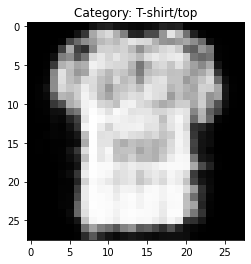

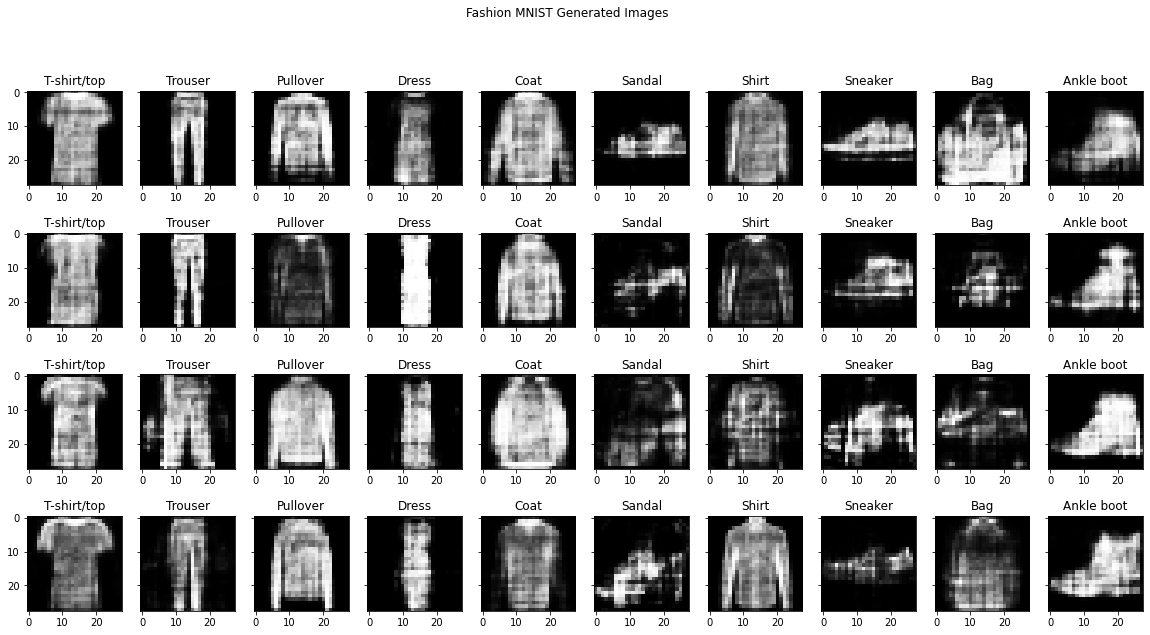

In [5]:
# Create the models
        
G = Generator().to(device)
D = Discriminator().to(device)

# Define the Optimizer
## TODO ##
lr = 1e-4
optimizer_g = torch.optim.Adam(G.parameters(),lr=lr)
optimizer_d = torch.optim.Adam(D.parameters(),lr=lr)
## TODO ##

# Define the Washerstein Loss functions
lamda = 10


def get_WLoss_generator(fake_images, labels):
    ## TODO ##
    fake_scores = D(fake_images,labels)
    return -fake_scores.mean()
    ## TODO ##


def get_WLoss_discriminator(fake_images, true_images, labels):
    ## TODO ##
    fake_scores = D(fake_images,labels)
    true_scores = D(true_images,labels)
    return fake_scores.mean()-true_scores.mean()
    ## TODO ##


def get_gradient_regularisation(fake_images, true_images, labels):
    ## TODO ##
    return lamda*((torch.sqrt((get_grad(fake_images, true_images, labels)**2).sum(dim=1))-1)**2).mean()
    ## TODO ##


def get_grad(fake_images, true_images, labels):
    epsilon = torch.FloatTensor(np.random.uniform(
        size=(fake_images.shape[0], 1, 1, 1))).to(device)
    xbar = epsilon*true_images + (1-epsilon)*fake_images
    xbar.requires_grad_()
    lipschitz_grad = grad(
        outputs=D(xbar, labels).sum(),
        inputs=xbar,
        create_graph=True,
        retain_graph=True)[0]
    return lipschitz_grad.view(xbar.shape[0], -1)

# Train Function
# returns the total loss for the epoch


def train(epoch):
    loss_acc_g = 0
    loss_acc_d = 0

    for i, (images, labels) in tqdm(enumerate(trainloader), desc="Training for epoch {}".format(epoch), total=len(trainloader)):
        images = images.to(device)
        labels = labels.to(device)
        # Discriminator Training
        optimizer_d.zero_grad()
        ## TODO ##
        fake_images = G(torch.empty(images.shape[0],100,1,1).normal_().to(device),labels).detach()
        loss_d = get_gradient_regularisation(fake_images,images,labels)+get_WLoss_discriminator(fake_images, images, labels)
        loss_d.backward()
        ## TODO ##
        optimizer_d.step()

        if i % 5 == 0:
            # Generator training
            optimizer_g.zero_grad()
            ## TODO ##
            fake_images = G(torch.empty(images.shape[0],100,1,1).normal_().to(device),labels)
            loss_g = get_WLoss_generator(fake_images, labels)
            loss_g.backward()
            ## TODO ##
            optimizer_g.step()
            loss_acc_g += loss_g.item()
        loss_acc_d += loss_d.item()

    return (loss_acc_g/(i/5)+loss_acc_d/i), loss_acc_g/(i/5), loss_acc_d/i


# Functions to save and load checkpoints
# Enter the path on your shared drive where the checkpoint is to be saved
## TODO ##
# For example path_to_checkpoint = '/content/drive/Shareddrives/CS763Lab8/'
path_to_checkpoint = './checkpoints'
## TODO ##


def save_checkpoint(e):
    if not os.path.isdir(path_to_checkpoint):
        os.mkdir(path_to_checkpoint)
    torch.save({'e': e, 'gen': G.state_dict(), 'disc': D.state_dict(), 'optim_d': optimizer_d.state_dict(
    ), 'optim_g': optimizer_g.state_dict()}, os.path.join(path_to_checkpoint, 'checkpoint_cwgan.pth'))


def load_checkpoint():
    if not os.path.isfile(os.path.join(path_to_checkpoint, 'checkpoint_cwgan.pth')):
        return -1
    dic = torch.load(os.path.join(path_to_checkpoint, 'checkpoint_cwgan.pth'))
    G.load_state_dict(dic['gen'])
    D.load_state_dict(dic['disc'])
    optimizer_d.load_state_dict(dic['optim_d'])
    optimizer_g.load_state_dict(dic['optim_g'])
    return dic['e']

# The generate functions are defined here
# Should return a nx28x28 numpy array


def generate(n, ci):
    if (type(ci) == int or type(ci) == float):
        ci = [ci]
    ## TODO ##
    fake_images = G(torch.empty(n,100,1,1).normal_().to(device),torch.LongTensor(ci).to(device)).detach()
    return fake_images.detach().cpu().numpy()
    ## TODO ##


## TODO ##
NUM_EPOCHS = 100
## TODO ##
losses_g = []
losses_d = []

# Resume training
offset = load_checkpoint()
if os.path.exists('images'):
    if offset == -1:
        os.system('rm -rf images')
        os.mkdir('images')
else:
    os.mkdir('images')


for e in range(NUM_EPOCHS):
    if e <= offset:
        continue
    loss, loss_g, loss_d = train(e)
    losses_g.append(loss_g)
    losses_d.append(loss_d)
    G.eval()
    li = torch.randint(0, 10, (1,))[0].item()
    g_output = generate(1, li)[0]
    G.train()
    plt.imshow(g_output.reshape(28, 28), cmap='gray')
    plt.title('Category: {}'.format(labeldic[li]))
    plt.savefig('./images/{}.png'.format(e))
    print('loss_g = {}, loss_d = {}\n'.format(loss_g, loss_d))
    save_checkpoint(e)

# Test script
load_checkpoint()
with torch.no_grad():
    G.eval()
    fig, axs = plt.subplots(4, 10, sharey=True, figsize=(20, 10))
    for i in range(40):
        fake_image = generate(1, i % 10)[0]
        axs[i//10, i % 10].imshow(fake_image.reshape(28, 28), cmap='gray')
        axs[i//10, i % 10].set_title('{}'.format(labeldic[i % 10]))
    plt.suptitle('Fashion MNIST Generated Images')
    plt.show()
